# Binary Classification with a Tabular Stroke Prediction Dataset

## About the Dataset

The dataset for this competition (both train and test) was generated from a deep learning model trained on the Stroke Prediction Dataset. Feature distributions are close to, but not exactly the same, as the original. Feel free to use the original dataset as part of this competition, both to explore differences as well as to see whether incorporating the original in training improves model performance.

<https://www.kaggle.com/competitions/playground-series-s3e2/data>

## Imports

In [184]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from imblearn.under_sampling import NearMiss
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from xgboost import plot_importance
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Reading the data

In [185]:
df = pd.read_csv('train.csv')

In [186]:
df.info() , df.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15304 entries, 0 to 15303
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 15304 non-null  int64  
 1   gender             15304 non-null  object 
 2   age                15304 non-null  float64
 3   hypertension       15304 non-null  int64  
 4   heart_disease      15304 non-null  int64  
 5   ever_married       15304 non-null  object 
 6   work_type          15304 non-null  object 
 7   Residence_type     15304 non-null  object 
 8   avg_glucose_level  15304 non-null  float64
 9   bmi                15304 non-null  float64
 10  smoking_status     15304 non-null  object 
 11  stroke             15304 non-null  int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 1.4+ MB


(None, 0)

## EDA + Cleaning

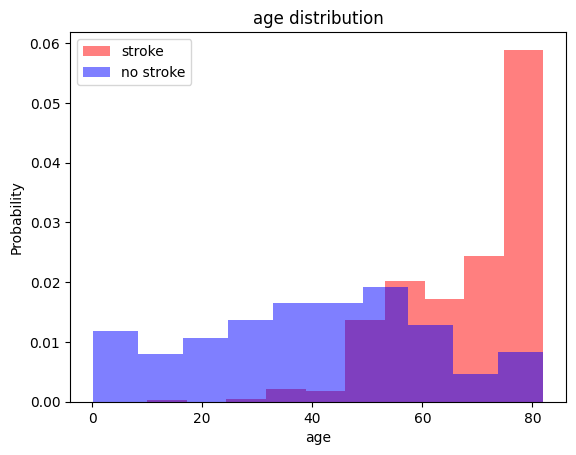

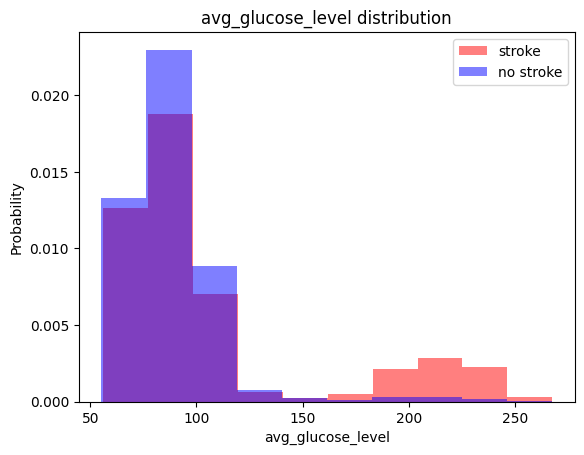

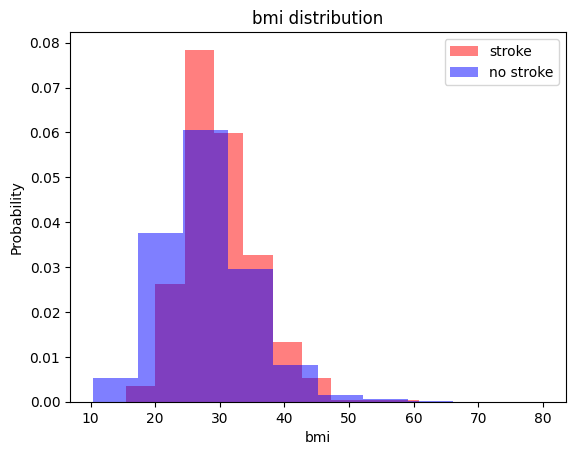

In [187]:
for feature in non_cat_features_cont:
    plt.hist(df[df['stroke']==1][feature], color='red', label='stroke', alpha=0.5, density=True)
    plt.hist(df[df['stroke']==0][feature], color='blue',label='no stroke', alpha=0.5, density=True)
    plt.title(f'{feature} distribution')
    plt.ylabel('Probability')
    plt.xlabel(feature)
    plt.legend()
    plt.show()    

In [188]:
#Cleaning
id_clear = df[df['gender']=='Other'].index[0]
df.drop(id_clear, inplace=True)
df.drop('id', axis=1, inplace=True)
df.reset_index(inplace=True)
df.drop('index', axis=1, inplace=True)

In [189]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,28.0,0,0,Yes,Private,Urban,79.53,31.1,never smoked,0
1,Male,33.0,0,0,Yes,Private,Rural,78.44,23.9,formerly smoked,0
2,Female,42.0,0,0,Yes,Private,Rural,103.00,40.3,Unknown,0
3,Male,56.0,0,0,Yes,Private,Urban,64.87,28.8,never smoked,0
4,Female,24.0,0,0,No,Private,Rural,73.36,28.8,never smoked,0


In [190]:
non_cat_features = df.dtypes[df.dtypes != 'object'].index.to_list()
categorical_features = df.dtypes[df.dtypes == 'object'].index.to_list()
print(non_cat_features , categorical_features)

['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'stroke'] ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']


In [191]:
df[non_cat_features].corr()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
age,1.000000,0.232624,0.193394,0.108933,0.390630,0.261319
hypertension,0.232624,1.000000,0.074176,0.122838,0.106651,0.145892
heart_disease,0.193394,0.074176,1.000000,0.137151,0.054571,0.111516
avg_glucose_level,0.108933,0.122838,0.137151,1.000000,0.108177,0.149278
bmi,0.390630,0.106651,0.054571,0.108177,1.000000,0.065377
stroke,0.261319,0.145892,0.111516,0.149278,0.065377,1.000000


In [192]:
non_cat_features_cont = ['age', 'avg_glucose_level', 'bmi']

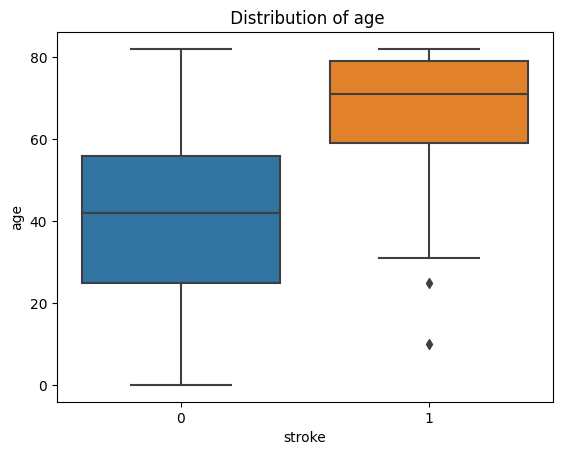

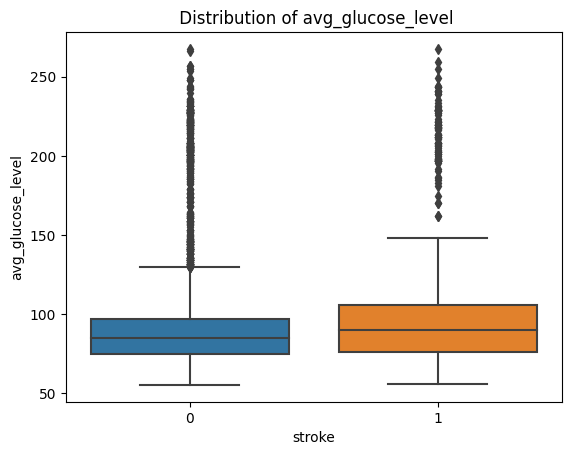

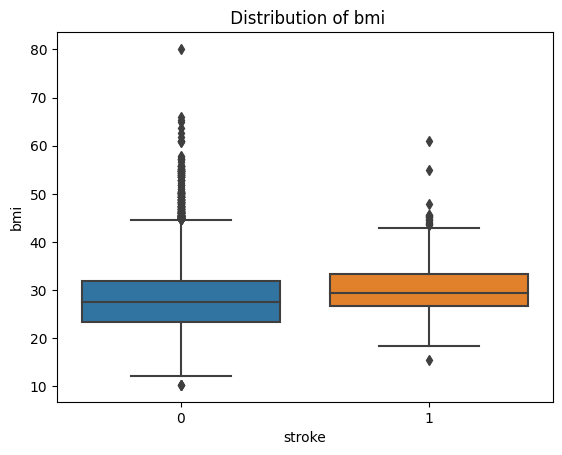

In [193]:
for feature in non_cat_features_cont:
    sns.boxplot(data=df, x='stroke', y=feature)
    plt.title(f' Distribution of {feature}')
    plt.show()

In [194]:
df[(df['stroke']==1) & (df['age']<30)]

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1065,Male,25.0,0,0,Yes,Private,Rural,90.43,26.1,Unknown,1
3226,Male,10.0,0,0,No,children,Urban,93.28,18.4,Unknown,1


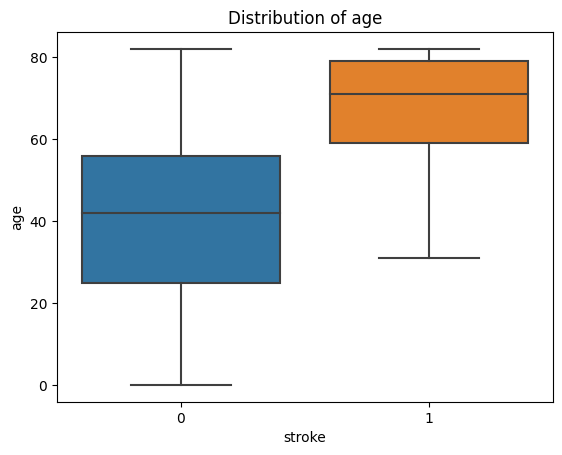

In [195]:
df.drop(df[(df['stroke']==1) & (df['age']<30)].index, inplace=True)
df.reset_index(inplace=True)
sns.boxplot(data=df, x='stroke', y='age')
plt.title('Distribution of age')
plt.show()


In [196]:
df.loc[(df['bmi']<16) & (df['stroke']==1)]

,index,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
652,652,Male,79.0,0,0,Yes,Private,Rural,78.68,15.5,formerly smoked,1


In [197]:
df[(df['bmi']>52) & (df['stroke']==1)]

,index,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
6843,6845,Male,76.0,1,0,Yes,Self-employed,Urban,68.12,60.9,formerly smoked,1
12063,12065,Male,73.0,0,0,Yes,Private,Rural,198.33,55.0,never smoked,1


In [198]:
df.drop('index', axis=1, inplace=True)
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,28.0,0,0,Yes,Private,Urban,79.53,31.1,never smoked,0
1,Male,33.0,0,0,Yes,Private,Rural,78.44,23.9,formerly smoked,0
2,Female,42.0,0,0,Yes,Private,Rural,103.00,40.3,Unknown,0
3,Male,56.0,0,0,Yes,Private,Urban,64.87,28.8,never smoked,0
4,Female,24.0,0,0,No,Private,Rural,73.36,28.8,never smoked,0


## OHE

In [199]:
ohe = OneHotEncoder(drop='if_binary')
x_array = ohe.fit_transform(df[categorical_features]).toarray()
ohef_df = pd.DataFrame(x_array, columns=ohe.get_feature_names_out(categorical_features))
ohef_df.head()

,gender_Male,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [200]:
df.drop(categorical_features, axis=1, inplace=True)
ohe_df = pd.concat([df, ohef_df], axis=1)
ohe_df.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Male,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,28.0,0,0,79.53,31.1,0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,33.0,0,0,78.44,23.9,0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,42.0,0,0,103.00,40.3,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,56.0,0,0,64.87,28.8,0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,24.0,0,0,73.36,28.8,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Undersampling

In [201]:
X = ohe_df.drop('stroke', axis=1)
y = ohe_df['stroke']
nm = NearMiss()
X_res, y_res = nm.fit_resample(X,y)

## Train Test Split

In [202]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, train_size=0.8, random_state=42)

## Testing XGBOOST (CV ROC score)

In [203]:
xgbc = XGBClassifier(gamma=0.4, learning_rate=0.05, max_depth=3, min_child_weight=4)

print(cross_val_score(xgbc, X_res, y_res, scoring='roc_auc', cv=5))
mean_score = cross_val_score(xgbc, X_res, y_res, scoring='roc_auc', cv=5).mean()
std_score = cross_val_score(xgbc, X_res, y_res, scoring='roc_auc', cv=5).std()
y_pred = cross_val_predict(xgbc, X_res, y_res, cv=5)
print(f' mean_score: {mean_score}, std_score: {std_score}')

[0.83254598 0.83169564 0.78420257 0.77664399 0.69334215]
 mean_score: 0.7836860670194004, std_score: 0.05080175409248454


## Testing CATBOOST (CV ROC score)

In [204]:
cbc = CatBoostClassifier()

print(cross_val_score(cbc, X_res, y_res, scoring='roc_auc', cv=5))
mean_score = cross_val_score(cbc, X_res, y_res, scoring='roc_auc', cv=5).mean()
std_score = cross_val_score(cbc, X_res, y_res, scoring='roc_auc', cv=5).std()
y_pred = cross_val_predict(cbc, X_res, y_res, cv=5)
print(f' mean_score: {mean_score}, std_score: {std_score}')

Learning rate set to 0.010337
0:	learn: 0.6904700	total: 3.34ms	remaining: 3.34s
1:	learn: 0.6875097	total: 7.65ms	remaining: 3.81s
2:	learn: 0.6845979	total: 10.8ms	remaining: 3.58s
3:	learn: 0.6817788	total: 13.7ms	remaining: 3.41s
4:	learn: 0.6787746	total: 16.7ms	remaining: 3.32s
5:	learn: 0.6759918	total: 19.8ms	remaining: 3.29s
6:	learn: 0.6733024	total: 24.4ms	remaining: 3.46s
7:	learn: 0.6709432	total: 27.4ms	remaining: 3.4s
8:	learn: 0.6689535	total: 31.5ms	remaining: 3.47s
9:	learn: 0.6662497	total: 34.6ms	remaining: 3.43s
10:	learn: 0.6635882	total: 38.7ms	remaining: 3.48s
11:	learn: 0.6614222	total: 41.8ms	remaining: 3.44s
12:	learn: 0.6590099	total: 44.8ms	remaining: 3.4s
13:	learn: 0.6569498	total: 48.4ms	remaining: 3.41s
14:	learn: 0.6544229	total: 51.5ms	remaining: 3.38s
15:	learn: 0.6522245	total: 55.5ms	remaining: 3.41s
16:	learn: 0.6493886	total: 59.2ms	remaining: 3.42s
17:	learn: 0.6471384	total: 62.9ms	remaining: 3.43s
18:	learn: 0.6443539	total: 65.2ms	remaining: 

## LIGHTGBM (CV ROC score)

In [205]:
lgbmc = LGBMClassifier(force_col_wise=True)

print(cross_val_score(lgbmc, X_res, y_res, scoring='roc_auc', cv=5))
mean_score = cross_val_score(lgbmc, X_res, y_res, scoring='roc_auc', cv=5).mean()
std_score = cross_val_score(lgbmc, X_res, y_res, scoring='roc_auc', cv=5).std()
y_pred = cross_val_predict(lgbmc, X_res, y_res, cv=5)
print(f' mean_score: {mean_score}, std_score: {std_score}')

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 504, number of negative: 504
[LightGBM] [Info] Total Bins 467
[LightGBM] [Info] Number of data points in the train set: 1008, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 504, number of negative: 504
[LightGBM] [Info] Total Bins 468
[LightGBM] [Info] Number of data points in the train set: 1008, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 504, number of negative: 504
[LightGBM] [Info] Total Bins 468
[LightGBM] [Info] Number of data points in the train set: 1008, number of used features: 15
[LightGBM] [Info] [binary:

## XGBOOST + ROC curve (Chosen model)

In [206]:
xgbc.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.4, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [207]:
xgbc.fit(X_train, y_train)
y_pred = xgbc.predict(X_test)

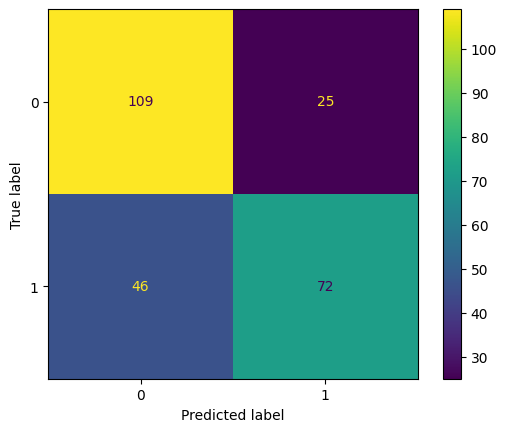

In [209]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [210]:
cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.70      0.81      0.75       134
           1       0.74      0.61      0.67       118

    accuracy                           0.72       252
   macro avg       0.72      0.71      0.71       252
weighted avg       0.72      0.72      0.71       252



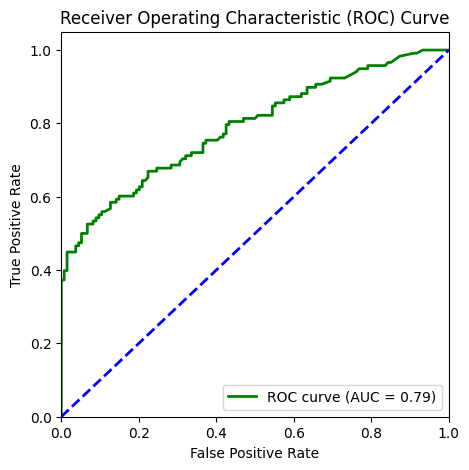

In [211]:
y_pred_proba = xgbc.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)


plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, color='green', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

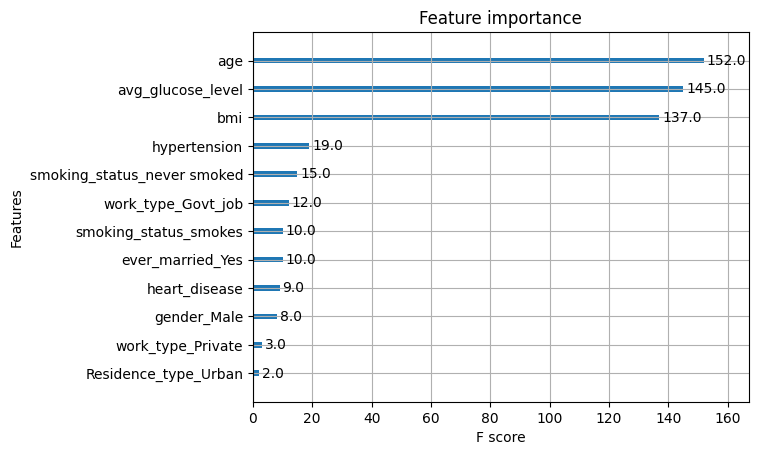

In [212]:
xgbc.fit(X_res, y_res)
plot_importance(xgbc)
plt.show()